In [1]:
! nvidia-smi

Thu May  5 12:27:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0  On |                  N/A |
| 46%   49C    P8    42W / 350W |    308MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from time import time
from typing import Callable, Dict, Optional
import matplotlib.pylab as plt
from onnxruntime import IOBinding
import numpy as np
import onnx
import torch
from onnx import GraphProto, ModelProto, helper
from torch.nn import Linear
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, PretrainedConfig, T5ForConditionalGeneration, TensorType
from transformers.generation_utils import GenerationMixin
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, Seq2SeqLMOutput
from transformers.models.t5.modeling_t5 import T5Stack

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding
from transformer_deploy.backends.pytorch_utils import convert_to_onnx

# Loading Hugging Face model / tokenizer

We use a specific branch of OnnxRuntime with a better management of if/else/then ONNX node:

```shell
git clone --recursive https://github.com/Microsoft/onnxruntime
cd onnxruntime
git fetch origin hari/location_plan_implicit_inputs
git checkout -b hari/location_plan_implicit_inputs FETCH_HEAD
CUDACXX=/usr/local/cuda-11.4/bin/nvcc ./build.sh \
    --config Release \
    --build_wheel \
    --parallel \
    --use_cuda \
    --cuda_home /usr/local/cuda-11.4 \
    --cudnn_home /usr/lib/x86_
    -linux-gnu/ \
    --skip_test
```

> to clear previous compilation, delete content of `./build` folder

In [3]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_ids: torch.Tensor = tokenizer("Studies show that", return_tensors=TensorType.PYTORCH).input_ids
input_ids = input_ids.to("cuda")
model: T5ForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.eval()
model = model.to("cuda")
model.config.use_cache = True
out_enc: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
out_full: Seq2SeqLMOutput = model(input_ids=input_ids, decoder_input_ids=input_ids)
num_layers = model.config.num_layers


def are_equal(a: torch.Tensor, b: torch.Tensor, atol: float = 2e-1) -> None:
    assert np.allclose(a=a.detach().cpu().numpy(), b=b.detach().cpu().numpy(), atol=atol), f"{a}\n\nVS\n\n{b}"

# Export to ONNX

## Export encoder part

In [4]:
model = model.to("cuda")

convert_to_onnx(
    model_pytorch=model.encoder,
    output_path="test-enc.onnx",
    inputs_pytorch={"input_ids": input_ids},
    var_output_seq=True,
    quantization=False,
)

enc_onnx = create_model_for_provider("test-enc.onnx", "CUDAExecutionProvider")
enc_onnx_out = inference_onnx_binding(
    model_onnx=enc_onnx,
    inputs={"input_ids": input_ids},
    device=input_ids.device.type,
)["output"]

are_equal(a=enc_onnx_out, b=out_enc.last_hidden_state)

## Export decoder

### Wrapper to include some post processing on the decoder output

The post processing is mainly a projection of the decoder output on a matrix with one of its dimension equal to model vocabulary size, so we have scores for each possible token.

In [5]:
from typing import Tuple


class ExportT5(torch.nn.Module):
    def __init__(self, decoder: T5Stack, lm_head: Linear):
        super(ExportT5, self).__init__()
        self.decoder = decoder
        self.lm_head = lm_head

    def forward(self, input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, past_key_values: Tuple = None):
        out_dec = self.decoder.forward(
            input_ids=input_ids, encoder_hidden_states=encoder_hidden_states, past_key_values=past_key_values
        )
        # Rescale output before projecting on vocab
        out_dec["last_hidden_state"] = out_dec["last_hidden_state"] * (model.model_dim**-0.5)
        out_dec["last_hidden_state"] = self.lm_head(out_dec["last_hidden_state"])
        return out_dec


model.cuda()
model_decoder = ExportT5(decoder=model.decoder, lm_head=model.lm_head).eval()
out_model_export: torch.Tensor = model_decoder(input_ids=input_ids, encoder_hidden_states=out_enc.last_hidden_state)

are_equal(a=out_model_export["last_hidden_state"], b=out_full.logits)

### Export decoder part to ONNX

Export 2 versions of the decoder, one without cache support and one with it.
Both models share most of their weights.

In [6]:
model_decoder.cuda()
# decoder output one step before
out_dec_pytorch = model_decoder(input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc.last_hidden_state)

model_inputs = {
    "input_ids": input_ids[:, -1:].type(torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
    "past_key_values": out_dec_pytorch.past_key_values,
}

# TODO replace hard coded axis names by generated one when generation works as expected
input_names = ["input_ids", "encoder_hidden_states"]

for i in range(num_layers):
    input_names.append(f"past_key_values.{i}.decoder.key")
    input_names.append(f"past_key_values.{i}.decoder.value")
    input_names.append(f"past_key_values.{i}.encoder.key")
    input_names.append(f"past_key_values.{i}.encoder.value")

output_names = ["logits"]

for i in range(num_layers):
    output_names.append(f"present.{i}.decoder.key")
    output_names.append(f"present.{i}.decoder.value")
    output_names.append(f"present.{i}.encoder.key")
    output_names.append(f"present.{i}.encoder.value")

dynamic_axis = {
    "input_ids": {0: "batch", 1: "encoder_sequence"},
    "encoder_hidden_states": {0: "batch", 1: "encoder_sequence"},
    "logits": {0: "batch", 1: "decoder_sequence"},
}


for i in range(num_layers):
    dynamic_axis[f"past_key_values.{i}.decoder.key"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.decoder.value"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.encoder.key"] = {0: "batch", 2: "past_encoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.encoder.value"] = {0: "batch", 2: "past_encoder_sequence"}

    dynamic_axis[f"present.{i}.decoder.key"] = {0: "batch", 2: "past_decoder_sequence + sequence"}
    dynamic_axis[f"present.{i}.decoder.value"] = {0: "batch", 2: "past_decoder_sequence + sequence"}
    dynamic_axis[f"present.{i}.encoder.key"] = {0: "batch", 2: "past_encoder_sequence"}
    dynamic_axis[f"present.{i}.encoder.value"] = {0: "batch", 2: "past_encoder_sequence"}


with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs,),
        f="test-dec-cache.onnx",
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axis,
        do_constant_folding=True,
        opset_version=13,
    )

model_inputs_no_cache = {
    "input_ids": input_ids.type(dtype=torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
}

with torch.no_grad():
    model.config.return_dict = True
    model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs_no_cache,),
        f="test-dec-no-cache.onnx",
        input_names=list(model_inputs_no_cache.keys()),
        output_names=output_names,
        dynamic_axes={k: v for k, v in dynamic_axis.items() if "past_key_values" not in k},
        do_constant_folding=True,
        opset_version=13,
    )
_ = model_decoder.cpu()  # free cuda memory

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/modeling_utils.py:529: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_mask.shape[1] < attention_mask.shape[1]:
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode


# Conversion to FP16

The only truly random input is `input ids` (aka token ids).
The range of realistic values of `input ids` is known: each dimension can only be a positive integer lower than the vocabulary size.
For other inputs of the model (ouput of encoder, past states), it's a bit more complicated.
In theory it can be any value in the FP32 range, but because of how models are initialized and trained, most of them are close to 0.
To avoid too  much guessing, we have decided to just take the output of the real model being fed random `input ids`.

In [7]:
from transformer_deploy.backends.ort_utils import get_keep_fp32_nodes
from transformer_deploy.backends.ort_utils import convert_fp16


def get_random_input_no_cache() -> Dict[str, torch.Tensor]:
    batch = 2
    seq_len = 512
    random_input_ids = torch.randint(
        low=2, high=tokenizer.vocab_size, size=(batch, seq_len), dtype=torch.int32, device="cuda"
    )
    inputs = {"input_ids": random_input_ids}
    encoder_hidden_states = inference_onnx_binding(
        model_onnx=enc_onnx,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )["output"]
    inputs["encoder_hidden_states"] = encoder_hidden_states
    return inputs


keep_fp32_no_cache = get_keep_fp32_nodes(
    onnx_model_path="test-dec-no-cache.onnx", get_input=get_random_input_no_cache, nb_try=1000
)

onnx_model_no_cache_fp16 = onnx.load("test-dec-no-cache.onnx")
onnx_model_no_cache_fp16 = convert_fp16(onnx_model=onnx_model_no_cache_fp16, nodes_to_exclude=keep_fp32_no_cache)
onnx.save(onnx_model_no_cache_fp16, "test-dec-no-cache-fp16.onnx")

In [8]:
dec_no_cache_ort_model = create_model_for_provider("test-dec-no-cache.onnx", "CUDAExecutionProvider")

# thread sur FP16 marche pas
# https://github.com/microsoft/onnxruntime/issues/11119=
# use info from tokenizer size and max shape provided through the command line
def get_random_input_cache() -> Dict[str, torch.Tensor]:
    inputs = get_random_input_no_cache()
    dec_past_states = inference_onnx_binding(
        model_onnx=dec_no_cache_ort_model,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )
    for k, v in dec_past_states.items():
        if k == "logits":
            continue
        new_k = k.replace("present", "past_key_values")
        inputs[new_k] = v
    batch, _ = inputs["input_ids"].shape
    complement = torch.randint(low=0, high=tokenizer.vocab_size, size=(batch, 1), dtype=torch.int32, device="cuda")
    inputs["input_ids"] = torch.concat(tensors=[inputs["input_ids"], complement], dim=1)
    return inputs


keep_fp32_cache = get_keep_fp32_nodes(
    onnx_model_path="test-dec-cache.onnx", get_input=get_random_input_cache, nb_try=1000
)

onnx_model_cache_fp16 = onnx.load("test-dec-cache.onnx")
onnx_model_cache_fp16 = convert_fp16(onnx_model=onnx_model_cache_fp16, nodes_to_exclude=keep_fp32_cache)
onnx.save(onnx_model_cache_fp16, "test-dec-cache-fp16.onnx")
del dec_no_cache_ort_model  # free cuda memory

### Merge ONNX computation graph to deduplicate weights

TODO remove unecessary initializer to avoid warning messages

In [9]:
prefix = "cache_node_"
mapping_initializer_cache_to_no_cache = dict()
to_add = list()
for node_cache in onnx_model_cache_fp16.graph.initializer:
    found = False
    for node_no_cache in onnx_model_no_cache_fp16.graph.initializer:
        if node_cache.raw_data == node_no_cache.raw_data:
            found = True
            mapping_initializer_cache_to_no_cache[node_cache.name] = node_no_cache.name
            break
    if not found:
        node_cache.name = prefix + node_cache.name
        to_add.append(node_cache)
        mapping_initializer_cache_to_no_cache[node_cache.name] = node_cache.name
        print(f"name: {node_cache.name} - size: {len(node_cache.raw_data)/1024:.2f}")

onnx_model_no_cache_fp16.graph.initializer.extend(to_add)
# I/O model names should not be prefixed
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

for node in onnx_model_cache_fp16.graph.node:
    for index, input_name in enumerate(node.input):
        if input_name in model_io_names:
            continue
        node.input[index] = mapping_initializer_cache_to_no_cache.get(input_name, prefix + input_name)
    for index, output_name in enumerate(node.output):
        if output_name in model_io_names:
            continue
        node.output[index] = prefix + output_name
    node.name = prefix + node.name
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

prefix = "init_"
cache = dict()
for node in onnx_model_no_cache_fp16.graph.initializer:
    if node.name in model_io_names:
        new_name = prefix + node.name
        cache[node.name] = new_name
        node.name = new_name

for node in onnx_model_no_cache_fp16.graph.node:
    for input_index, n in enumerate(node.input):
        node.input[input_index] = cache.get(n, n)

# mandatory for subgraph in if/else node
assert len(onnx_model_cache_fp16.graph.output) == len(onnx_model_no_cache_fp16.graph.output)

graph_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_cache_fp16.graph.node),
    name="graph-cache",
    inputs=[],
    outputs=list(onnx_model_cache_fp16.graph.output),
    initializer=[],
)

graph_no_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_no_cache_fp16.graph.node),
    name="graph-no-cache",
    inputs=[],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=[],
)

enable_cache_input = onnx.helper.make_tensor_value_info(name="enable_cache", elem_type=onnx.TensorProto.BOOL, shape=[1])

if_node = onnx.helper.make_node(
    op_type="If",
    inputs=["enable_cache"],
    outputs=[o.name for o in list(onnx_model_no_cache_fp16.graph.output)],
    then_branch=graph_cache,
    else_branch=graph_no_cache,
)

if_graph_def: GraphProto = helper.make_graph(
    nodes=[if_node],
    name="if-model",
    inputs=list(onnx_model_cache_fp16.graph.input) + [enable_cache_input],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=list(onnx_model_no_cache_fp16.graph.initializer),
)


model_def: ModelProto = helper.make_model(
    if_graph_def, producer_name="onnx-example", opset_imports=[helper.make_opsetid(onnx.defs.ONNX_DOMAIN, 13)]
)
onnx.save(model_def, "test-dec-if.onnx")

name: cache_node_onnx::Slice_2276 - size: 0.01
name: cache_node_onnx::Slice_2277 - size: 0.01
name: cache_node_onnx::Slice_2287 - size: 0.01
name: cache_node_onnx::Slice_2288 - size: 0.01


When a name appears in both the initializer list and the graph input list, a runtime MAY allow a caller to specify a value for this (input) name overriding the value specified in the initializer and a runtime MAY allow users to omit specifying a value for this (input) name, choosing the value specified in the initializer. Names of constants that are not meant to be overridden by the caller should appear only in the initializer list and not in the graph input list. In models with IR version >= 4, in nested subgraphs used as attribute values, users MUST NOT use the same name as both a subgraph initializer and subgraph input unless the corresponding op's specification explicitly allows it. In models with IR version <= 3, users MAY use the same name as both a subgraph initializer and subgraph input, but this is restricted to support constants via initializers that are not intended to correspond to any actual inputs passed from the node into the subgraph. In particular, the control-flow operator semantics determines the set of inputs supplied to the execution of the subgraph, and these input names MUST NOT appear as subgraph initializers. Subgraph initializer names must appear in the graph input list after the actual inputs. This allows the actual inputs and formal inputs to be matched positionally.
https://github.com/onnx/onnx/blob/ee4888c24510787bb8c61ebcba43ef252744e648/docs/IR.md

### Check ONNX decoder output

Compare ONNX output with and without cache, plus compare with Pytorch output.

In [10]:
model = model.cuda()
model_decoder = model_decoder.cuda()
input_ids = input_ids.cuda()
model = model.eval()
model_decoder = model_decoder.eval()
enc_onnx = create_model_for_provider("test-enc.onnx", "CUDAExecutionProvider")
enc_onnx_binding: IOBinding = enc_onnx.io_binding()
dec_onnx = create_model_for_provider(model_def.SerializeToString(), "CUDAExecutionProvider")
dec_onnx_binding: IOBinding = dec_onnx.io_binding()

2022-05-05 11:35:20.128309369 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_803'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.128328267 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_954'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.128332213 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_702'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.128335633 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_1709'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.128338993 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Div_652'. It is not

## Benchmark new model on real scenario

TODO: print graph of cache / no cache latency for each seq len + show how to justify what we measure
TODO: convert the model to FP16 + add some explanation regarding aggressive conversion https://pytorch.org/docs/stable/amp.html?utm_source=pocket_mylist
TODO: add experiment with TensorRT in mixed precision
TODO: try https://github.com/microsoft/onnxruntime/pull/11320 + https://github.com/microsoft/onnxruntime/pull/8702 + https://github.com/microsoft/onnxruntime/issues/11254

In [11]:
with torch.inference_mode():
    out_enc_pytorch: BaseModelOutputWithPastAndCrossAttentions = model.encoder(input_ids=input_ids)
    previous_step_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )
    out_dec_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids, encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )

initializer 'cache_node_onnx::Pow_948'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.187375310 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Add_1857'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.187380298 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Add_2209'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.187383946 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Pow_1451'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.187387639 [W:onnxruntime:, graph.cc:3515 CleanUnusedInitializersAndNodeArgs] Removing initializer 'cache_node_onnx::Add_1924'. It is not used by any node and should be removed from the model.
2022-05-05 11:35:20.187390793 [W:onnxruntime:, 

In [12]:
def decoder_pytorch_inference(decoder_input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, **_):
    with torch.inference_mode():
        return model_decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_hidden_states)


def decoder_onnx_inference(
    decoder_input_ids: torch.Tensor,
    encoder_hidden_states: torch.Tensor,
    enable_cache: torch.Tensor,
    past_key_values: Optional[torch.Tensor],
):
    inputs_onnx_dict = {
        "input_ids": decoder_input_ids,
        "encoder_hidden_states": encoder_hidden_states,
        "enable_cache": enable_cache,
    }

    if past_key_values is not None:
        for index, (k_dec, v_dec, k_enc, v_enc) in enumerate(past_key_values):
            inputs_onnx_dict[f"past_key_values.{index}.decoder.key"] = k_dec
            inputs_onnx_dict[f"past_key_values.{index}.decoder.value"] = v_dec
            inputs_onnx_dict[f"past_key_values.{index}.encoder.key"] = k_enc
            inputs_onnx_dict[f"past_key_values.{index}.encoder.value"] = v_enc

    result_dict = inference_onnx_binding(
        model_onnx=dec_onnx,
        inputs=inputs_onnx_dict,
        binding=dec_onnx_binding,  # recycle the binding
        device=decoder_input_ids.device.type,
        clone_tensor=False,  # no memory copy -> best perf and lowest memory footprint!
    )
    past_states = list()
    for index in range(model.config.num_layers):
        kv = (
            result_dict[f"present.{index}.decoder.key"],
            result_dict[f"present.{index}.decoder.value"],
            result_dict[f"present.{index}.encoder.key"],
            result_dict[f"present.{index}.encoder.value"],
        )
        past_states.append(kv)
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=result_dict["logits"],
        past_key_values=past_states,
    )


out_dec_onnx_no_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids,
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([False], device="cuda", dtype=torch.bool),
    past_key_values=None,
)
are_equal(a=out_dec_onnx_no_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_no_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_no_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [13]:
out_dec_onnx_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids[:, -1:],
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([True], device="cuda", dtype=torch.bool),
    past_key_values=previous_step_pytorch.past_key_values,
)

are_equal(a=out_dec_onnx_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [14]:
def encoder_onnx_inference(input_ids: torch.Tensor, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    last_hidden_state = inference_onnx_binding(
        model_onnx=enc_onnx,  # noqa: F821
        inputs={"input_ids": input_ids},
        device=input_ids.device.type,
        binding=enc_onnx_binding,
    )["output"]
    return BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=last_hidden_state.type(torch.float32))


def encoder_pytorch_inference(input_ids, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    with torch.inference_mode():
        res = model.encoder(input_ids=input_ids).type(torch.float32)
        return res


# https://github.com/NVIDIA/TensorRT/blob/main/demo/HuggingFace/T5/export.py
class ExtT5(torch.nn.Module, GenerationMixin):
    def __init__(self, config: PretrainedConfig, device: torch.device, encoder_func: Callable, decoder_func: Callable):
        super(ExtT5, self).__init__()
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803
        self.config: PretrainedConfig = config
        self.device: torch.device = device

        self.encoder_func = encoder_func
        self.decoder_func = decoder_func
        self.use_cache = True
        self.timings = list()

    def get_encoder(self):
        return self.encoder_func

    def get_decoder(self):
        return self.decoder_func

    def set_cache(self, enable: bool) -> None:
        self.use_cache = enable

    # from transformers library (modeling_t5.py)
    def _reorder_cache(self, past, beam_idx):
        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

    def prepare_inputs_for_generation(self, input_ids, past=None, use_cache=None, **kwargs) -> Dict[str, torch.Tensor]:
        params = {
            "encoder_hidden_states": kwargs["encoder_outputs"]["last_hidden_state"],
        }
        if past is None:  # this is the 1st inferred token
            self.timings = list()
        if not self.use_cache:
            past = None
        if past is None:
            params[self.main_input_name] = input_ids
            params["enable_cache"] = torch.tensor([False], device="cuda", dtype=torch.bool)
        else:
            params[self.main_input_name] = input_ids[:, -1:]
            params["enable_cache"] = torch.tensor([True], device="cuda", dtype=torch.bool)
            params["past_key_values"] = past

        return params

    def forward(
        self,
        input_ids: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        enable_cache: torch.Tensor,
        past_key_values: Optional[torch.Tensor] = None,
        **_,
    ):
        start_timer = time()
        dec_output = self.get_decoder()(
            decoder_input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            enable_cache=enable_cache,
            past_key_values=past_key_values,
        )
        self.timings.append(time() - start_timer)
        return Seq2SeqLMOutput(logits=dec_output.last_hidden_state, past_key_values=dec_output.past_key_values)


model_gen = (
    ExtT5(
        config=model.config,
        device=model.device,
        encoder_func=encoder_onnx_inference,  # encoder_pytorch_inference
        decoder_func=decoder_onnx_inference,  # decoder_pytorch_inference
    )
    .cuda()
    .eval()
)

torch.cuda.synchronize()
with torch.inference_mode():
    print(
        tokenizer.decode(
            model_gen.generate(
                inputs=input_ids,
                min_length=30,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=False,
        )
    )
    print(
        tokenizer.decode(
            model.generate(
                input_ids=input_ids,
                min_length=30,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=False,
        )
    )

<pad> study shows that 80% of the world's population is affluent or faecially affiliated.</s>
<pad><extra_id_0>.<extra_id_1>. Studies show that 80% of the world's population is influenced by dietary habits. Research shows that the majority of people who are overweight or obese are more likely to be obese than their peers.</s>


In [15]:
from nvtx import nvtx
from copy import copy

content_len = 1400
num_beam = 4

with nvtx.annotate("ONNX", color="red"):
    model_gen.set_cache(enable=False)
    start = time()
    model_gen.generate(inputs=input_ids, max_length=content_len, num_beams=num_beam, min_length=content_len)
    print(f"ONNX: {time() - start}")
    print(f"model: {sum(model_gen.timings)}")
    timing_onnx_no_cache = model_gen.timings

with nvtx.annotate("ONNX", color="red"):
    model_gen.set_cache(enable=True)
    start = time()
    model_gen.generate(inputs=input_ids, max_length=content_len, num_beams=num_beam, min_length=content_len)
    print(f"ONNX + cache: {time() - start}")
    print(f"model: {sum(model_gen.timings)}")
    timing_onnx_cache = model_gen.timings

# monckey patching of forward function to add a timer per generated token
old_fw = model.forward
timing_pytorch = list()


def new_fw(self, *args, **kwargs):
    timer_start = time()
    res = old_fw(self, *args, **kwargs)
    torch.cuda.synchronize()  # makes timings correct without having significant impact on e2e latency
    timing_pytorch.append(time() - timer_start)
    return res


model.forward = new_fw.__get__(model)

with nvtx.annotate("Pytorch", color="orange"):
    model.config.use_cache = False
    with torch.inference_mode():
        with torch.cuda.amp.autocast():
            start = time()
            model.generate(inputs=input_ids, max_length=content_len, num_beams=num_beam, min_length=content_len)
            torch.cuda.synchronize()
            print(f"Pytorch: {time() - start}")
            print(f"model: {sum(timing_pytorch)}")
    timing_pytorch_no_cache = copy(timing_pytorch)
    timing_pytorch.clear()

with nvtx.annotate("Pytorch + cache", color="green"):
    model.config.use_cache = True
    with torch.inference_mode():
        with torch.cuda.amp.autocast():
            start = time()
            model.generate(inputs=input_ids, max_length=content_len, num_beams=num_beam, min_length=content_len)
            torch.cuda.synchronize()
            print(f"Pytorch + cache: {time() - start}")
            print(f"model: {sum(timing_pytorch)}")
    timing_pytorch_cache = copy(timing_pytorch)
    timing_pytorch.clear()
model.forward = old_fw

ONNX: 45.13586139678955
model: 42.57213044166565
ONNX + cache: 13.34917950630188
model: 11.047776699066162
Pytorch: 78.02505421638489
model: 76.64945149421692
Pytorch + cache: 22.538686990737915
model: 20.461787700653076


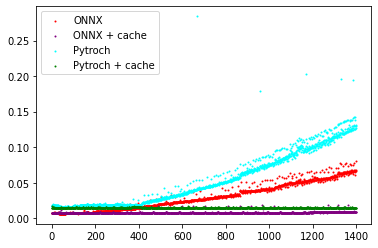

In [16]:
axis = range(len(timing_onnx_no_cache))
plt.scatter(axis, timing_onnx_no_cache, marker="o", color="red", label="ONNX", s=1)
plt.scatter(axis, timing_onnx_cache, marker="o", color="purple", label="ONNX + cache", s=1)
plt.scatter(axis, timing_pytorch_no_cache, marker="o", color="cyan", label="Pytroch", s=1)
plt.scatter(axis, timing_pytorch_cache, marker="o", color="green", label="Pytroch + cache", s=1)
plt.legend()

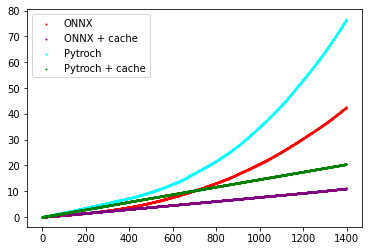

In [17]:
axis = range(len(timing_onnx_no_cache))
plt.scatter(axis, np.cumsum(timing_onnx_no_cache), marker="o", color="red", label="ONNX", s=1)
plt.scatter(axis, np.cumsum(timing_onnx_cache), marker="o", color="purple", label="ONNX + cache", s=1)
plt.scatter(axis, np.cumsum(timing_pytorch_no_cache), marker="o", color="cyan", label="Pytroch", s=1)
plt.scatter(axis, np.cumsum(timing_pytorch_cache), marker="o", color="green", label="Pytroch + cache", s=1)
plt.legend()

# TODO change axis name to better describe what they are, in particular manage encoder and decoder models with common names


link to https://github.com/microsoft/onnxruntime/pull/10651 !